# clean workflow for processing dataframes.

This notebook:
1. merges the replicate read counts for pre- and post-seleciton barcodes counts.
2. cleans the pacbio mutant calls by filtering for length and the exact barcode lengths
3. merges the readcounts with the pacbio mutant calls
4. removes PCR artefacts arising in the Illumina Truseq amplification region
5. corrects extremely prevalent mutations found in pacbio reads, which often arise in poly-nucleotide repeat regions
6. finally shifts the mutants to be indexed by the transcriptional start site.


Requires:
1. per sample counted illumina barcodes
2. consensus called barcode -> mutation mapping from pacbio.


In [ ]:
import pandas as pd
from glob import glob
import numpy as np
import os
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import sys
sys.path.append('../../src/')

import importlib
import constants
from constants import sample_to_positions, sample_to_length, gene_to_approx_bc_pos, sample_to_truseq_exclude
import pacbio
import illumina as il
from illumina import create_lrr_file, merge_replicates, drop_bc_nan_filter_len

import nucleotides as nt
import plotting as pt


dout ='/data/davidding/dms/dms_plants/data/clean/illumina/'
sample_dout ='/data/davidding/dms/dms_plants/data/clean/illumina/sample_lrr/'



# 1. create log read ratio files for each sample (illumina)   

In [ ]:
# matches the raw barcode count files, and calculates a log read ratio.
# write out to dout + 'sample_lrr/'

# create per sample log read ratio files
dna_to_rna_files = [
    ('2B_DNA_rep12_sorghum', '2B_rep1_sorghum'),
    ('2B_DNA_rep12_sorghum', '2B_rep2_sorghum'),
    ('2C_DNA_rep12_sorghum', '2C_rep1_sorghum'),
    ('2C_DNA_rep12_sorghum', '2C_rep2_sorghum'),
    ('2B_DNA_rep34_sorghum', '2B_rep3_sorghum'),
    ('2B_DNA_rep34_sorghum', '2B_rep4_sorghum'),
    ('3A_DNA_rep12_sorghum', '3A_rep1_sorghum'),
    ('3A_DNA_rep12_sorghum', '3A_rep2_sorghum'),
    ('3B_DNA_rep12_sorghum', '3B_rep1_sorghum'),
    ('3B_DNA_rep12_sorghum', '3B_rep2_sorghum'),
    ('3C_DNA_rep12_sorghum', '3C_rep1_sorghum'),
    ('3C_DNA_rep12_sorghum', '3C_rep2_sorghum'),
    ('3B_DNA_rep3_sorghum', '3B_rep3_sorghum'),
    ('3C_DNA_rep3_sorghum', '3C_rep3_sorghum'),
    ('2C_DNA_rice', '2C_rep1_rice'),
    ('2C_DNA_rice', '2C_rep2_rice'),
    ('3B_DNA_rice', '3B_rep1_rice'),
    ('3B_DNA_rice', '3B_rep2_rice'),
    ('3B_DNA_rice', '3B_rep3_rice')
]

# place where the raw count files are stored per sample
illumina_dir = '/data/davidding/dms/illumina_data/PROTOPLASTSUMMER24-425876467/BCLConvert_07_28_2024_02_06_09Z-753277525/'

count_files = [f for f in glob(illumina_dir+'**/*bc.csv', recursive=True)]
f_to_path = dict([(f.split('/')[-1].split('.')[0], f) for f in count_files])

for (n_dna, n_rna) in dna_to_rna_files:

    f_dna = f_to_path[n_dna.lower()]
    f_rna = f_to_path[n_rna.lower()]

    df_dna = pd.read_csv(f_dna)
    df_rna = pd.read_csv(f_rna)

    # making sure to merge on outer to not miss mutants.
    df_merge = pd.merge(df_dna, df_rna, on='bc', how='outer', suffixes=('_dna', '_rna'))
    print(len(df_dna), len(df_rna), len(df_merge))

    # adding a pseudocount to dna
    df_merge['bc_count_dna'] = df_merge['bc_count_dna'].fillna(0)
    df_merge['bc_count_dna'] = df_merge['bc_count_dna'] +1

    # adding a pseudocount to rna
    df_merge['bc_count_rna'] = df_merge['bc_count_rna'].fillna(0)
    df_merge['bc_count_rna'] = df_merge['bc_count_rna'] +1

    # add a log read ratio
    n_reads_dna = df_merge.bc_count_dna.sum()
    n_reads_rna = df_merge.bc_count_rna.sum()
    df_merge['lrr'] = df_merge.apply(lambda r: np.log(r.bc_count_rna/n_reads_rna) - np.log(r.bc_count_dna/n_reads_dna), axis=1)
    
    f_name_out = n_rna + '_lrr.csv'
    df_merge.to_csv(sample_dout+f_name_out, index=False)

85536 63081 98503
85536 73606 106339
88043 57413 108814
88043 51882 105002
288815 165929 327349
288815 177382 336055
115421 110405 162507
115421 104153 159522
228 445 658
228 252 469
393090 328519 475778
393090 268534 455086
179787 161195 265392
179787 171359 273557
421025 152289 449372
199917 136684 265545
147166 125289 208511
147166 107699 197285
379187 154206 417635
379187 143057 412523
379187 156736 420029


## create sample log read ratio files for 2A: synthetic SBPase libraries

In [ ]:
# create initial lrr files for each replicate

illumina_dir = "/data/davidding/dms/illumina_data/missing2a/"

fa_files = [f for f in glob(illumina_dir+'**/*bc.csv', recursive=True)]
f_to_path = dict([(f.split('/')[-1], f) for f in fa_files])
for f in f_to_path.keys():
    print(f)
# sorghum 2A , rep1
create_lrr_file(
    f_to_path['sorghum2A_DNA_S6_L001_.extendedFrags_filtered_bc.csv'], 
    f_to_path['sorghum2A1_RNA_S4_L001_.extendedFrags_filtered_bc.csv'], 
    illumina_dir)

# sorghum 2A , rep2
create_lrr_file(
    f_to_path['sorghum2A_DNA_S6_L001_.extendedFrags_filtered_bc.csv'], 
    f_to_path['sorghum2A2_RNA_S5_L001_.extendedFrags_filtered_bc.csv'], 
    illumina_dir)

# rice 2A , rep1
create_lrr_file(
    f_to_path['rice2A_DNA_S3_L001_.extendedFrags_filtered_bc.csv'], 
    f_to_path['rice2A1_RNA_S1_L001_.extendedFrags_filtered_bc.csv'], 
    illumina_dir)

# rice 2A , rep2
create_lrr_file(
    f_to_path['rice2A_DNA_S3_L001_.extendedFrags_filtered_bc.csv'], 
    f_to_path['rice2A2_RNA_S2_L001_.extendedFrags_filtered_bc.csv'], 
    illumina_dir)

# merge replicates
df_rice_2A = merge_replicates(
    '2A_rice', 
    ['rice2A1_RNA_S1_L001_.extendedFrags_filtered_bc',
     'rice2A2_RNA_S2_L001_.extendedFrags_filtered_bc'], illumina_dir)

df_sorghum_2A = merge_replicates(
    '2A_sorghum', 
    ['sorghum2A1_RNA_S4_L001_.extendedFrags_filtered_bc',
     'sorghum2A2_RNA_S5_L001_.extendedFrags_filtered_bc'], illumina_dir)

df_rice_2A.to_csv(illumina_dir + 'reps/2A_rice_lrr.csv', index=False)
df_sorghum_2A.to_csv(illumina_dir + 'reps/2A_sorghum_lrr.csv', index=False)

rice2A1_RNA_S1_L001_.extendedFrags_filtered_bc.csv
rice2A2_RNA_S2_L001_.extendedFrags_filtered_bc.csv
rice2A_DNA_S3_L001_.extendedFrags_filtered_bc.csv
sorghum2A1_RNA_S4_L001_.extendedFrags_filtered_bc.csv
sorghum2A_DNA_S6_L001_.extendedFrags_filtered_bc.csv
sorghum2A2_RNA_S5_L001_.extendedFrags_filtered_bc.csv
97189 102892 125400
97189 90884 115120
84522 84933 97965
84522 93005 105084


# 2. merging the sample lrr replicate for each gene and condition



In [ ]:

sample_to_reps ={
    '2B_sorghum' : ['2B_rep1_sorghum', '2B_rep2_sorghum', '2B_rep3_sorghum', '2B_rep4_sorghum'],
    '2C_sorghum' : ['2C_rep1_sorghum', '2C_rep2_sorghum'],
    '3A_sorghum': ['3A_rep1_sorghum', '3A_rep2_sorghum'],
    '3B_sorghum': ['3B_rep1_sorghum', '3B_rep2_sorghum', '3B_rep3_sorghum'],
    '3C_sorghum': ['3C_rep1_sorghum', '3C_rep2_sorghum', '3C_rep3_sorghum'],
    '2C_rice': ['2C_rep1_rice', '2C_rep2_rice'],
    '3B_rice': ['3B_rep1_rice', '3B_rep2_rice', '3B_rep3_rice']
}

# only merging reps 1 and 2
for sample, list_reps  in sample_to_reps.items():
    print(sample, list_reps)

    list_dfs = []
    #### replicate 1
    df1 = pd.read_csv(sample_dout + list_reps[0] + '_lrr.csv')
    df1 = drop_bc_nan_filter_len(df1, list_reps[0])
    # rename columns to keep track in merged dataframe
    dic_col_rename1 = dict(zip(df1.columns, [ c+'_'+ list_reps[0].split('_')[1] if c != 'bc' else 'bc' for c in df1.columns ]))
    df1 = df1.rename(columns=dic_col_rename1)
    list_dfs.append(df1)
    #### replicate 2
    df2 = pd.read_csv(sample_dout + list_reps[1] + '_lrr.csv')
    df2 = drop_bc_nan_filter_len(df2, list_reps[1])
    # rename columns to keep track in merged dataframe
    dic_col_rename2 = dict(zip(df2.columns, [ c+'_'+ list_reps[1].split('_')[1] if c != 'bc' else 'bc' for c in df2.columns ]))
    df2 = df2.rename(columns=dic_col_rename2)
    list_dfs.append(df2)
    
    # merging on barcodes
    df_merged = df1.merge(df2, on ='bc', how='outer')
    df_merged['mean_lrr'] = df_merged.apply(lambda r: np.mean([r.lrr_rep1, r.lrr_rep2]), axis=1)


    
    if len(list_reps) >2:
        #### replicate 3
        df3 = pd.read_csv(sample_dout + list_reps[2] + '_lrr.csv')
        df3 = drop_bc_nan_filter_len(df3, list_reps[2])
        # rename columns to keep track in merged dataframe
        dic_col_rename3 = dict(zip(df3.columns, [ c+'_'+ list_reps[2].split('_')[1] if c != 'bc' else 'bc' for c in df3.columns ]))
        df3 = df3.rename(columns=dic_col_rename3)
        list_dfs.append(df3)

        # merging on barcodes
        df_merged = df_merged.merge(df3, on ='bc', how='outer')
        # keep a column mean_lrr for only replicates 1&2
        df_merged['mean_lrr'] = df_merged.apply(lambda r: np.mean([r.lrr_rep1, r.lrr_rep2]), axis=1)
        df_merged['mean_lrr_all'] = df_merged.apply(lambda r: np.mean([r.lrr_rep1, r.lrr_rep2, r.lrr_rep3]), axis=1)

    if len(list_reps) >3:
        #### replicate 4
        df4 = pd.read_csv(sample_dout + list_reps[3] + '_lrr.csv')
        df4 = drop_bc_nan_filter_len(df4, list_reps[3])
        # rename columns to keep track in merged dataframe
        dic_col_rename4 = dict(zip(df4.columns, [ c+'_'+ list_reps[3].split('_')[1] if c != 'bc' else 'bc' for c in df4.columns]))
        df4 = df4.rename(columns=dic_col_rename4)
        list_dfs.append(df4)

        # merging on barcodes
        df_merged = df_merged.merge(df4, on ='bc', how='outer')
        df_merged['mean_lrr'] = df_merged.apply(lambda r: np.mean([r.lrr_rep1, r.lrr_rep2]), axis=1)
        df_merged['mean_lrr_all'] = df_merged.apply(lambda r: np.mean([r.lrr_rep1, r.lrr_rep2, r.lrr_rep3, r.lrr_rep4]), axis=1)
    


    for df in list_dfs:
        print(len(df))
    print(f'merged df: {len(df_merged)}')
    print(df_merged.columns)
    display(df_merged)

    df_merged.to_csv(dout + 'reps/' + sample + '_lrr.csv', index=False)
    print(len(df_merged))

2B_sorghum ['2B_rep1_sorghum', '2B_rep2_sorghum', '2B_rep3_sorghum', '2B_rep4_sorghum']
for rep 2B_rep1_sorghum: 
 droppedn from 98503: 
  after dropna: 98502 
 after bc length filtering: 95971


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))
/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 2B_rep2_sorghum: 
 droppedn from 106339: 
  after dropna: 106338 
 after bc length filtering: 103446


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 2B_rep3_sorghum: 
 droppedn from 162507: 
  after dropna: 162506 
 after bc length filtering: 157216


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 2B_rep4_sorghum: 
 droppedn from 159522: 
  after dropna: 159521 
 after bc length filtering: 154639
95971
103446
157216
154639
merged df: 236176
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'bc_count_dna_rep3', 'bc_count_rna_rep3',
       'lrr_rep3', 'len_bc_rep3', 'mean_lrr_all', 'bc_count_dna_rep4',
       'bc_count_rna_rep4', 'lrr_rep4', 'len_bc_rep4'],
      dtype='object')


,bc,bc_count_dna_rep1,bc_count_rna_rep1,lrr_rep1,len_bc_rep1,bc_count_dna_rep2,bc_count_rna_rep2,lrr_rep2,len_bc_rep2,mean_lrr,bc_count_dna_rep3,bc_count_rna_rep3,lrr_rep3,len_bc_rep3,mean_lrr_all,bc_count_dna_rep4,bc_count_rna_rep4,lrr_rep4,len_bc_rep4
0,XXX,1231699.0,715798.0,-0.021997,3.0,1231699.0,1254982.0,-0.016606,3.0,-0.019302,3774656.0,5495452.0,-0.019113,3.0,-0.020620,3774656.0,4481440.0,-0.024763,3.0
1,TCATGCAATGGTTTA,3195.0,1879.0,-0.010093,15.0,3195.0,3375.0,0.019475,15.0,0.004691,10032.0,15878.0,0.064430,15.0,-0.008756,10032.0,10950.0,-0.108839,15.0
2,TGAAGTCGCGGAGGT,12222.0,7129.0,-0.018312,15.0,12222.0,12802.0,0.011031,15.0,-0.003640,40300.0,63987.0,0.067604,15.0,0.029781,40300.0,52016.0,0.058802,15.0
3,ATATTAACGGATAGA,32758.0,19081.0,-0.019699,15.0,32758.0,33876.0,-0.001773,15.0,-0.010736,101111.0,150155.0,0.000724,15.0,0.009521,101111.0,130510.0,0.058833,15.0
4,ACCGTGAGATTTTTT,64.0,51.0,0.293697,15.0,64.0,105.0,0.459744,15.0,0.376721,217.0,234.0,-0.319301,15.0,-0.029568,217.0,152.0,-0.552415,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236171,GTGTTACTATGCGAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.496749,15.0
236172,TCCCGGTGTAAAATT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.496749,15.0
236173,CACATTGTGTCATGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.496749,15.0
236174,TTAGACACGTGCGTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.496749,15.0


236176
2C_sorghum ['2C_rep1_sorghum', '2C_rep2_sorghum']
for rep 2C_rep1_sorghum: 
 droppedn from 108814: 
  after dropna: 108813 
 after bc length filtering: 105590


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))
/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 2C_rep2_sorghum: 
 droppedn from 105002: 
  after dropna: 105001 
 after bc length filtering: 101962
105590
101962
merged df: 120155
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr'],
      dtype='object')


,bc,bc_count_dna_rep1,bc_count_rna_rep1,lrr_rep1,len_bc_rep1,bc_count_dna_rep2,bc_count_rna_rep2,lrr_rep2,len_bc_rep2,mean_lrr
0,XXX,1466094.0,653993.0,-0.021312,3.0,1466094.0,680599.0,-0.027796,3.0,-0.024554
1,GTATCGGGAATTTAT,761.0,345.0,-0.005140,15.0,761.0,382.0,0.050375,15.0,0.022617
2,GTTTCTCGGTTGGTG,943.0,463.0,0.074610,15.0,943.0,498.0,0.101121,15.0,0.087865
3,TCAATGGAGCCTGCA,746.0,328.0,-0.035763,15.0,746.0,335.0,-0.061007,15.0,-0.048385
4,AAATACCATTGTTTT,732.0,378.0,0.125062,15.0,732.0,369.0,0.054604,15.0,0.089833
...,...,...,...,...,...,...,...,...,...,...
120150,GCGGTCGTTCGAGGC,NaN,NaN,NaN,NaN,1.0,2.0,1.432735,15.0,NaN
120151,AGCTTTTACTCTGTT,NaN,NaN,NaN,NaN,1.0,2.0,1.432735,15.0,NaN
120152,TACTACCGAAGATTG,NaN,NaN,NaN,NaN,1.0,2.0,1.432735,15.0,NaN
120153,TATTATAAATTTCTA,NaN,NaN,NaN,NaN,1.0,2.0,1.432735,15.0,NaN


120155
2D_sorghum ['2D_rep1_sorghum', '2D_rep2_sorghum']


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 2D_rep1_sorghum: 
 droppedn from 327349: 
  after dropna: 327348 
 after bc length filtering: 319511


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 2D_rep2_sorghum: 
 droppedn from 336055: 
  after dropna: 336054 
 after bc length filtering: 327617
319511
327617
merged df: 361729
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr'],
      dtype='object')


,bc,bc_count_dna_rep1,bc_count_rna_rep1,lrr_rep1,len_bc_rep1,bc_count_dna_rep2,bc_count_rna_rep2,lrr_rep2,len_bc_rep2,mean_lrr
0,XXX,4247732.0,1235436.0,-0.001017,3.0,4247732.0,1615479.0,-0.015202,3.0,-0.008110
1,TTCTCGTTTTATGGG,1250.0,349.0,-0.041883,15.0,1250.0,479.0,-0.007647,15.0,-0.024765
2,ACAGGGAACCTGGTT,748.0,244.0,0.113709,15.0,748.0,272.0,-0.060050,15.0,0.026830
3,CCCTCTTTAATACCT,636.0,165.0,-0.115309,15.0,636.0,236.0,-0.039815,15.0,-0.077562
4,ACGGTTATAGCCTTT,809.0,214.0,-0.095879,15.0,809.0,306.0,-0.020662,15.0,-0.058271
...,...,...,...,...,...,...,...,...,...,...
361724,CAATACGCCAATCGG,NaN,NaN,NaN,NaN,1.0,2.0,1.644699,15.0,NaN
361725,CCGAGTACATTTACG,NaN,NaN,NaN,NaN,1.0,2.0,1.644699,15.0,NaN
361726,AGGGTGGTCCACAAT,NaN,NaN,NaN,NaN,1.0,2.0,1.644699,15.0,NaN
361727,TTATCAACGGGAGAA,NaN,NaN,NaN,NaN,1.0,2.0,1.644699,15.0,NaN


361729
3A_sorghum ['3A_rep1_sorghum', '3A_rep2_sorghum']
for rep 3A_rep1_sorghum: 
 droppedn from 658: 
  after dropna: 658 
 after bc length filtering: 648
for rep 3A_rep2_sorghum: 
 droppedn from 469: 
  after dropna: 469 
 after bc length filtering: 463
648
463
merged df: 880
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr'],
      dtype='object')


,bc,bc_count_dna_rep1,bc_count_rna_rep1,lrr_rep1,len_bc_rep1,bc_count_dna_rep2,bc_count_rna_rep2,lrr_rep2,len_bc_rep2,mean_lrr
0,XXX,58085.0,1657.0,-0.854578,3.0,58085.0,920.0,-0.902643,3.0,-0.878611
1,CGTATATAATCCAAT,288.0,304.0,2.756388,15.0,288.0,185.0,2.800041,15.0,2.778215
2,CGTCCTCTCGCAGAT,2.0,1.0,2.009174,15.0,2.0,1.0,2.549499,15.0,2.279336
3,TATCCGCTACTATAT,43.0,35.0,2.496469,15.0,43.0,6.0,1.273205,15.0,1.884837
4,ACATCTCGAAATATA,271.0,215.0,2.470840,15.0,271.0,109.0,2.331875,15.0,2.401358
...,...,...,...,...,...,...,...,...,...,...
875,TGAGCGCGGTTGGAG,NaN,NaN,NaN,NaN,1.0,2.0,3.935793,15.0,NaN
876,GCAATGCGCCTTTAG,NaN,NaN,NaN,NaN,1.0,3.0,4.341258,15.0,NaN
877,GTATGGCTTTACTTC,NaN,NaN,NaN,NaN,1.0,2.0,3.935793,15.0,NaN
878,CAGAATTTTCATATT,NaN,NaN,NaN,NaN,1.0,2.0,3.935793,15.0,NaN


880
3B_sorghum ['3B_rep1_sorghum', '3B_rep2_sorghum', '3B_rep3_sorghum']


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 3B_rep1_sorghum: 
 droppedn from 475778: 
  after dropna: 475777 
 after bc length filtering: 469271


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 3B_rep2_sorghum: 
 droppedn from 455086: 
  after dropna: 455085 
 after bc length filtering: 449165


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 3B_rep3_sorghum: 
 droppedn from 449372: 
  after dropna: 449371 
 after bc length filtering: 444333
469271
449165
444333
merged df: 636809
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'bc_count_dna_rep3', 'bc_count_rna_rep3',
       'lrr_rep3', 'len_bc_rep3', 'mean_lrr_all'],
      dtype='object')


,bc,bc_count_dna_rep1,bc_count_rna_rep1,lrr_rep1,len_bc_rep1,bc_count_dna_rep2,bc_count_rna_rep2,lrr_rep2,len_bc_rep2,mean_lrr,bc_count_dna_rep3,bc_count_rna_rep3,lrr_rep3,len_bc_rep3,mean_lrr_all
0,XXX,9645357.0,9634877.0,0.040616,3.0,9645357.0,7883892.0,0.009789,3.0,0.025203,11929230.0,4589256.0,0.015357,3.0,0.021921
1,TTATTAAACCACTTT,2142.0,2675.0,0.263913,15.0,2142.0,2009.0,0.147341,15.0,0.205627,2650.0,1427.0,0.351646,15.0,0.254300
2,GTATTGGTATTCACC,4818.0,4678.0,0.012215,15.0,4818.0,3748.0,-0.039692,15.0,-0.013739,6263.0,2291.0,-0.035040,15.0,-0.020839
3,ACTTTTCTCTGAATG,415.0,330.0,-0.187483,15.0,415.0,233.0,-0.365796,15.0,-0.276639,528.0,132.0,-0.415663,15.0,-0.322981
4,CTGTTTTTTTACTTC,1891.0,1386.0,-0.268981,15.0,1891.0,1055.0,-0.372121,15.0,-0.320551,2545.0,724.0,-0.286463,15.0,-0.309188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636804,ATGTTGACGCACGGC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.663778,15.0,NaN
636805,TCTACGATTAGCCTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.663778,15.0,NaN
636806,AACCCTCTTCTTCGT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.663778,15.0,NaN
636807,TAATTCTAGATTGCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.663778,15.0,NaN


636809
3C_sorghum ['3C_rep1_sorghum', '3C_rep2_sorghum', '3C_rep3_sorghum']


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 3C_rep1_sorghum: 
 droppedn from 265392: 
  after dropna: 265391 
 after bc length filtering: 259248


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 3C_rep2_sorghum: 
 droppedn from 273557: 
  after dropna: 273556 
 after bc length filtering: 267073


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 3C_rep3_sorghum: 
 droppedn from 265545: 
  after dropna: 265544 
 after bc length filtering: 259598
259248
267073
259598
merged df: 469157
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'bc_count_dna_rep3', 'bc_count_rna_rep3',
       'lrr_rep3', 'len_bc_rep3', 'mean_lrr_all'],
      dtype='object')


,bc,bc_count_dna_rep1,bc_count_rna_rep1,lrr_rep1,len_bc_rep1,bc_count_dna_rep2,bc_count_rna_rep2,lrr_rep2,len_bc_rep2,mean_lrr,bc_count_dna_rep3,bc_count_rna_rep3,lrr_rep3,len_bc_rep3,mean_lrr_all
0,XXX,10116115.0,10364583.0,-0.100981,3.0,10116115.0,9074039.0,-0.248336,3.0,-0.174659,18090416.0,8028995.0,-0.252455,3.0,-0.200591
1,TAGAATATGCCGAAA,743.0,852.0,0.011644,15.0,743.0,806.0,-0.058236,15.0,-0.023296,1153.0,672.0,0.020003,15.0,-0.008863
2,AGAGCATTATTAACA,2.0,1.0,-0.818393,15.0,2.0,1.0,-0.832771,15.0,-0.825582,NaN,NaN,NaN,NaN,NaN
3,TTCGTTATTTTAGCC,1563.0,1937.0,0.089287,15.0,1563.0,1619.0,-0.104422,15.0,-0.007567,2951.0,1747.0,0.035624,15.0,0.006830
4,GGGTGTCCTATATAA,2.0,1.0,-0.818393,15.0,2.0,1.0,-0.832771,15.0,-0.825582,1.0,2.0,1.253015,15.0,-0.132716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469152,GTTCTTAAGGTTGGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.253015,15.0,NaN
469153,GATCATAGTGGATCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.253015,15.0,NaN
469154,ACCGAATCAAAAGAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.253015,15.0,NaN
469155,GCTTTAATAAATGAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.253015,15.0,NaN


469157
2C_rice ['2C_rep1_rice', '2C_rep2_rice']


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 2C_rep1_rice: 
 droppedn from 208511: 
  after dropna: 208510 
 after bc length filtering: 201709


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 2C_rep2_rice: 
 droppedn from 197285: 
  after dropna: 197284 
 after bc length filtering: 191061
201709
191061
merged df: 241510
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr'],
      dtype='object')


,bc,bc_count_dna_rep1,bc_count_rna_rep1,lrr_rep1,len_bc_rep1,bc_count_dna_rep2,bc_count_rna_rep2,lrr_rep2,len_bc_rep2,mean_lrr
0,XXX,4870648.0,3597548.0,0.026153,3.0,4870648.0,3564489.0,0.017078,3.0,0.021616
1,GCTCGAGGTGACTCA,5356.0,3627.0,-0.060684,15.0,5356.0,3323.0,-0.148065,15.0,-0.104374
2,GCGTTTCTTTCTAGA,296.0,222.0,0.041446,15.0,296.0,123.0,-0.548890,15.0,-0.253722
3,AACAGGAAAATTCTT,2090.0,1548.0,0.028928,15.0,2090.0,1365.0,-0.096725,15.0,-0.033899
4,TGATTTTATCTATTT,2789.0,1997.0,-0.004909,15.0,2789.0,2443.0,0.196828,15.0,0.095960
...,...,...,...,...,...,...,...,...,...,...
241505,CTAGTTTTTTTTCAG,NaN,NaN,NaN,NaN,1.0,2.0,1.022432,15.0,NaN
241506,TATTCAACTAAATTG,NaN,NaN,NaN,NaN,1.0,2.0,1.022432,15.0,NaN
241507,CCTAACTGTATACTC,NaN,NaN,NaN,NaN,1.0,2.0,1.022432,15.0,NaN
241508,GTTGTACTTGACATT,NaN,NaN,NaN,NaN,1.0,2.0,1.022432,15.0,NaN


241510
3B_rice ['3B_rep1_rice', '3B_rep2_rice', '3B_rep3_rice']


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 3B_rep1_rice: 
 droppedn from 417635: 
  after dropna: 417634 
 after bc length filtering: 412227


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 3B_rep2_rice: 
 droppedn from 412523: 
  after dropna: 412522 
 after bc length filtering: 407350


/tmp/ipykernel_112223/3528943850.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_bc'] = df.bc.apply(lambda x: len(x))


for rep 3B_rep3_rice: 
 droppedn from 420029: 
  after dropna: 420028 
 after bc length filtering: 414716
412227
407350
414716
merged df: 473320
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'bc_count_dna_rep3', 'bc_count_rna_rep3',
       'lrr_rep3', 'len_bc_rep3', 'mean_lrr_all'],
      dtype='object')


,bc,bc_count_dna_rep1,bc_count_rna_rep1,lrr_rep1,len_bc_rep1,bc_count_dna_rep2,bc_count_rna_rep2,lrr_rep2,len_bc_rep2,mean_lrr,bc_count_dna_rep3,bc_count_rna_rep3,lrr_rep3,len_bc_rep3,mean_lrr_all
0,XXX,11553817.0,6013299.0,-0.034152,3.0,11553817.0,5155204.0,-0.043710,3.0,-0.038931,11553817.0,6704970.0,-0.032247,3.0,-0.036703
1,TTCAGATGGAACTTA,20.0,1.0,-2.376842,15.0,20.0,1.0,-2.232434,15.0,-2.304638,20.0,1.0,-2.483813,15.0,-2.364363
2,ATGTCGGACAAGGAT,409.0,256.0,0.150353,15.0,409.0,154.0,-0.213464,15.0,-0.031555,409.0,215.0,-0.131158,15.0,-0.064756
3,CTATGGGACTGAGGG,1341.0,557.0,-0.259715,15.0,1341.0,461.0,-0.304474,15.0,-0.282095,1341.0,680.0,-0.167159,15.0,-0.243783
4,CATGAGTAGTTGATA,3027.0,1616.0,-0.008727,15.0,3027.0,1347.0,-0.046393,15.0,-0.027560,3027.0,1938.0,0.066004,15.0,0.003628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473315,TTAGTATTATATTCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.205067,15.0,NaN
473316,GTACGAATGTTCGTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.205067,15.0,NaN
473317,ATAAAAACGTGGTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.205067,15.0,NaN
473318,AAACGCGTTTTCTCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.205067,15.0,NaN


473320


# 3. clean consensus pacbio
- filtering 
- duplicate raw barcodes that are an error of minimapping
- for barcode size, 
- any pacbio consensus sequences that are too small.
- raw fastq barcode calling and consensus mut barcode extraction are the same (do not match when there are indels in barcode)


In [19]:

din_bc_mutant = '/data/szchen/dms/snakemake/consensus-calling/dfs/mutsBCDFs/'
dout_pacbio ='/data/davidding/dms/dms_plants/data/clean/pacbio/'


In [ ]:
for f in sorted([f for f in listdir(din_bc_mutant) if f.endswith('len.csv')]): 

    print('reading and processing:', f)
    gene_n = f.split('_')[1]

    df_bc = pd.read_csv(din_bc_mutant+f)
    #display(df_bc)

    # rename these columns to indicate that they are raw
    df_bc = df_bc[['bc', 'muts', 'seq_len']].rename(
        columns={
            'bc': 'raw_bc_with_5_5prime_bases',
            'muts': 'raw_muts', 
            'seq_len': 'consensus_seq_len'
            }
            )
    n_pre_drop = len(df_bc)

    # drop any duplicate raw_barcodes. These come from a tricky bug in how minimap handles reads that are truncated in the middle, but span the whole gene
    # there is a tricky bug, where reads that are truncated in the middle and missing large chunks, can get reported as 2 rows. 
    # exact cause from minimap2 unclear.
    list_occur_more_than_once_raw_barcodes = [x[0] for x in Counter(df_bc.raw_bc_with_5_5prime_bases).items() if x[1] > 1]
    print('list_occur_more_than_once_raw_barcodes', list_occur_more_than_once_raw_barcodes)
    df_bc = df_bc.loc[~df_bc.raw_bc_with_5_5prime_bases.isin(list_occur_more_than_once_raw_barcodes)]
    n_dedup = len(df_bc)

    # filter fragments out that are too short
    min_len = sample_to_length[gene_n]-600
    df_bc = df_bc.loc[df_bc.consensus_seq_len > min_len]
    n_after_seq_len = len(df_bc)

    # extract barcode and other mutations from the consensus mutations
    approx_pos = gene_to_approx_bc_pos[gene_n]
    df_bc[['bc','muts_orig_pos']] = df_bc.apply(
        lambda r: pacbio.get_bc_from_muts(r.raw_muts, pos_lim_min=approx_pos-20, pos_lim_max=approx_pos+40),
        axis='columns', 
        result_type='expand')

    # filter for barcodes with length 15 exactly.
    df_bc['len_bc'] = df_bc.bc.apply(lambda x: len(x))
    df_bc = df_bc.loc[df_bc.len_bc == 15]
    n_after_bc_len_filter = len(df_bc)

    # check that the bc_raw with the 5 prime over hang is matching exactly the mapped barcode from the consensu sequence
    df_bc['bc_from_raw_bc'] = df_bc.raw_bc_with_5_5prime_bases.apply(lambda x: x[5:])
    df_bc['matching_bcs'] = df_bc['bc_from_raw_bc'] == df_bc['bc']
    df_bc = df_bc.loc[df_bc.matching_bcs]
    n_post_matching_bcs = len(df_bc)
    print(f'fraction bcs matching from raw reads and from consensus muta extraction {float(n_post_matching_bcs)/float(n_after_bc_len_filter)}')

    print(f'droppgin from {n_pre_drop} to \n after dedup raw bcs: {n_dedup} \n after seq_len filter {n_after_seq_len} \n after bc_len filter: {n_after_bc_len_filter}  \n after matching bcs: {n_post_matching_bcs}')

    # check that wt are present
    print(f'number of wt barcodes', len(df_bc.loc[df_bc.muts_orig_pos == 'wt']))

    df_bc.to_csv(dout_pacbio + f'df_bc_{gene_n}.csv')
    #display(df_bc)


reading and processing: df_2A_AC_len.csv
list_occur_more_than_once_raw_barcodes ['AATAATCTAGTGCGTGACTT']
fraction bcs matching from raw reads and from consensus muta extraction 0.9937787136294027
droppgin from 32220 to 
 after dedup raw bcs: 32218 
 after seq_len filter 31469 
 after bc_len filter: 31344  
 after matching bcs: 31149
number of wt barcodes 452
reading and processing: df_2B_AC_len.csv
list_occur_more_than_once_raw_barcodes ['AATAAACAGACATAAATGTG', 'AATAAAGCAATTATTGTAAA', 'AATAAAGGTAACTTACCCAA', 'AATAAAGTCTGTCGCTCCGG', 'AATAACGTTGACTCAATGTT', 'AATAACTCTCAGATATTGGC', 'AATAACTTACAACTCGTGAT', 'AATAAGATCACCCTCTTCAA', 'AATAAGTAACTCCTTATTCA', 'AATAAGTCATATTTGTTCGT', 'AATAATACGTACTAGTTTTG', 'AATAATATCCTTAATGTGAT', 'AATAATGATTAGTCCGTACT', 'AATAATTAGTGCATCGATGA']
fraction bcs matching from raw reads and from consensus muta extraction 0.9736126224156693
droppgin from 45308 to 
 after dedup raw bcs: 45280 
 after seq_len filter 45061 
 after bc_len filter: 44112  
 after matching bcs

# 4. merging pacbio reads in:
- Note: significantly fewer barcodes in pacbio than illumina, but recovering a decent fraction of the pacbio barcodes in the illumina generally.

In [3]:
# reading in all pacbio files. 
din_bc = '/data/davidding/dms/dms_plants/data/clean/pacbio/'

#dictionary of sample, like '2A' to the long read files
sample_to_df_bc = dict([(f.split('_')[2][:2], pd.read_csv(din_bc + f)) for f in listdir(din_bc) if f.endswith('.csv')])

In [ ]:
dout_merged = '/data/davidding/dms/dms_plants/data/clean/illumina/lrr_muts/'

def merge_mutants_in(sample):
    print('processing sample:', sample)
    gene_id, species = sample.split('_')

    # get df_bc
    df_bc = sample_to_df_bc[gene_id]

    # get df_lrr
    df_lrr = pd.read_csv(dout + 'reps/' + sample + '_lrr.csv')

    # adding the mutant to dataframe
    df_bc_lrr = df_lrr.merge(df_bc, on='bc', how='inner')
    print(f'# barcodes from pacbio: {len(df_bc)} \n # barcodes in illumina {len(df_lrr)} \n # barcodes merged {len(df_bc_lrr)}')
    df_bc_lrr.to_csv(dout_merged + sample + '_lrr_bc.csv', index=False)

for sample in ['2B_sorghum', '2C_sorghum', '3A_sorghum', '3B_sorghum', '3C_sorghum', '2C_rice', '3B_rice']:
    merge_mutants_in(sample)


processing sample: 2B_sorghum
# barcodes from pacbio: 42948 
 # barcodes in illumina 236176 
 # barcodes merged 42930
processing sample: 2C_sorghum
# barcodes from pacbio: 26201 
 # barcodes in illumina 120155 
 # barcodes merged 26162
processing sample: 2D_sorghum
# barcodes from pacbio: 91948 
 # barcodes in illumina 361729 
 # barcodes merged 91894
processing sample: 3A_sorghum
# barcodes from pacbio: 100883 
 # barcodes in illumina 880 
 # barcodes merged 739
processing sample: 3B_sorghum
# barcodes from pacbio: 33126 
 # barcodes in illumina 636809 
 # barcodes merged 33117
processing sample: 3C_sorghum
# barcodes from pacbio: 47423 
 # barcodes in illumina 469157 
 # barcodes merged 47420
processing sample: 2C_rice
# barcodes from pacbio: 26201 
 # barcodes in illumina 241510 
 # barcodes merged 26194
processing sample: 3B_rice
# barcodes from pacbio: 33126 
 # barcodes in illumina 473320 
 # barcodes merged 33059


## for 2A

In [10]:
din_2A_lrr = '/data/davidding/dms/illumina_data/missing2a/reps/'
dout_merged = '/data/davidding/dms/dms_plants/data/clean/illumina/lrr_muts/'

def merge_2A(fin_lrr, df_longreads, fout):
    df_lrr = pd.read_csv(fin_lrr)
    #display(df_lrr)
    # Create bc column from bc_rep1 and bc_rep2, using non-NaN values
    df_lrr['bc'] = df_lrr.apply(lambda r: 
        r['bc_rep1'] if pd.notna(r['bc_rep1']) 
        else r['bc_rep2'] if pd.notna(r['bc_rep2'])
        else None, 
        axis=1)
    #display(df_longreads)
    df_merged = df_lrr.merge(df_longreads, on='bc', how='inner')
    print(f'# barcodes from pacbio: {len(df_longreads)} \n # barcodes in illumina {len(df_lrr)} \n # barcodes merged {len(df_merged)}')

    df_merged.to_csv(fout, index=False)

merge_2A(din_2A_lrr + '2A_rice_lrr.csv', sample_to_df_bc['2A'], dout_merged + '2A_rice_lrr_bc.csv')
merge_2A(din_2A_lrr + '2A_sorghum_lrr.csv', sample_to_df_bc['2A'], dout_merged + '2A_sorghum_lrr_bc.csv')


# barcodes from pacbio: 31149 
 # barcodes in illumina 114376 
 # barcodes merged 31124


/tmp/ipykernel_2073564/494171330.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lrr = pd.read_csv(fin_lrr)


# barcodes from pacbio: 31149 
 # barcodes in illumina 138184 
 # barcodes merged 31131


# 5. remove truseq mutations
- removing reads that have mutations in the barcode PCR priming site that drove spurious enrichment.

In [ ]:


dout_no_truseq = '/data/davidding/dms/dms_plants/data/clean/illumina/lrr_muts_no_forbidden/'

for f in listdir(dout_merged):
    print('processing:', f)
    gene_n = f.split('_')[0]
    sample_n = '_'.join(f.split('_')[:2])
    if gene_n in sample_to_truseq_exclude:
        df = pd.read_csv(dout_merged + f)
        print(df.columns)
        # not filtering for high read mutations
        list_forbidden = sample_to_truseq_exclude[gene_n]
        
        df, df_no_forbidden = get_forbidden_df(
            df,
            sample_n, 
            list_forbidden, 
            dout = dout_no_truseq, 
            mut_col = 'muts_orig_pos')

processing: 2C_sorghum_lrr_bc.csv
processing: 2D_sorghum_lrr_bc.csv
processing: 2C_rice_lrr_bc.csv
processing: 3B_sorghum_lrr_bc.csv
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'bc_count_dna_rep3', 'bc_count_rna_rep3',
       'lrr_rep3', 'len_bc_rep3', 'mean_lrr_all', 'Unnamed: 0',
       'raw_bc_with_5_5prime_bases', 'raw_muts', 'consensus_seq_len',
       'muts_orig_pos', 'len_bc', 'bc_from_raw_bc', 'matching_bcs'],
      dtype='object')


/tmp/ipykernel_112223/2139659261.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['list_pos_mut'] = df.apply(lambda r:[x[1] for x in nt.get_ind_muts(str(r[mut_col]))], axis=1)
/tmp/ipykernel_112223/2139659261.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mut_forbidden'] = df.apply(lambda r: any([x in list_forbidden for x in r.list_pos_mut]), axis=1)


filtering truseq mutations out filters out this many barcodes 1193 out of 33091
processing: 3B_rice_lrr_bc.csv
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'bc_count_dna_rep3', 'bc_count_rna_rep3',
       'lrr_rep3', 'len_bc_rep3', 'mean_lrr_all', 'Unnamed: 0',
       'raw_bc_with_5_5prime_bases', 'raw_muts', 'consensus_seq_len',
       'muts_orig_pos', 'len_bc', 'bc_from_raw_bc', 'matching_bcs'],
      dtype='object')


/tmp/ipykernel_112223/2139659261.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['list_pos_mut'] = df.apply(lambda r:[x[1] for x in nt.get_ind_muts(str(r[mut_col]))], axis=1)
/tmp/ipykernel_112223/2139659261.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mut_forbidden'] = df.apply(lambda r: any([x in list_forbidden for x in r.list_pos_mut]), axis=1)


filtering truseq mutations out filters out this many barcodes 1123 out of 32985
processing: 3C_sorghum_lrr_bc.csv
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'bc_count_dna_rep3', 'bc_count_rna_rep3',
       'lrr_rep3', 'len_bc_rep3', 'mean_lrr_all', 'Unnamed: 0',
       'raw_bc_with_5_5prime_bases', 'raw_muts', 'consensus_seq_len',
       'muts_orig_pos', 'len_bc', 'bc_from_raw_bc', 'matching_bcs'],
      dtype='object')


/tmp/ipykernel_112223/2139659261.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['list_pos_mut'] = df.apply(lambda r:[x[1] for x in nt.get_ind_muts(str(r[mut_col]))], axis=1)
/tmp/ipykernel_112223/2139659261.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mut_forbidden'] = df.apply(lambda r: any([x in list_forbidden for x in r.list_pos_mut]), axis=1)


filtering truseq mutations out filters out this many barcodes 783 out of 47401
processing: 2B_sorghum_lrr_bc.csv
processing: 3A_sorghum_lrr_bc.csv
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'Unnamed: 0', 'raw_bc_with_5_5prime_bases',
       'raw_muts', 'consensus_seq_len', 'muts_orig_pos', 'len_bc',
       'bc_from_raw_bc', 'matching_bcs'],
      dtype='object')
filtering truseq mutations out filters out this many barcodes 3 out of 188


/tmp/ipykernel_112223/2139659261.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['list_pos_mut'] = df.apply(lambda r:[x[1] for x in nt.get_ind_muts(str(r[mut_col]))], axis=1)
/tmp/ipykernel_112223/2139659261.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mut_forbidden'] = df.apply(lambda r: any([x in list_forbidden for x in r.list_pos_mut]), axis=1)


# 6. correct prevalent mutations to define a new reference sequence.
- ie. for mutations that occur >90% in all reads, make these the new reference, but only for substitutions

In [ ]:
dout_no_truseq = '/data/davidding/dms/dms_plants/data/clean/illumina/lrr_muts_no_forbidden/'

df = pd.read_csv(dout_no_truseq +  '3C_sorghum_no_forbidden.csv')

df['muts_opr']= df.muts_orig_pos.apply(lambda x: correct_prevalent_mutations(x, dic_sample_to_muts_prevalent['3C'])) 

df['muts_opr_no_i1592aa'] = df.muts_opr.apply(lambda x: ':'.join([m for m in x.split(':') if not m.startswith('I1592A')]))


,bc,bc_count_dna_rep1,bc_count_rna_rep1,lrr_rep1,len_bc_rep1,bc_count_dna_rep2,bc_count_rna_rep2,lrr_rep2,len_bc_rep2,mean_lrr,...,raw_muts,consensus_seq_len,muts_orig_pos,len_bc,bc_from_raw_bc,matching_bcs,list_pos_mut,mut_forbidden,muts_opr,muts_opr_no_i1592aa
0,TAGAATATGCCGAAA,743.0,852.0,0.011644,15.0,743.0,806.0,-0.058236,15.0,-0.023296,...,N1345T:N1346A:N1347G:N1348A:N1349A:N1350T:N135...,6888,I1592AAA:T5467C:T5470C,15,TAGAATATGCCGAAA,True,"[1592, 5467, 5470]",False,I1592AAA:T5467C:T5470C,T5467C:T5470C
1,TTCGTTATTTTAGCC,1563.0,1937.0,0.089287,15.0,1563.0,1619.0,-0.104422,15.0,-0.007567,...,N1345T:N1346T:N1347C:N1348G:N1349T:N1350T:N135...,6884,I1592AA:T2964C:G4018T:G4424A:A4987_:G5676T:G62...,15,TTCGTTATTTTAGCC,True,"[1592, 2964, 4018, 4424, 4987, 5676, 6225, 6226]",False,I1592AA:T2964C:G4018T:G4424A:A4987_:G5676T:G62...,T2964C:G4018T:G4424A:A4987_:G5676T:G6225_:C6226_
2,ATTAATCACCCAGCC,501.0,754.0,0.283540,15.0,501.0,612.0,0.060503,15.0,0.172021,...,N1345A:N1346T:N1347T:N1348A:N1349A:N1350T:N135...,6873,I1592AA:G2110A:A3594_:G3905A:A4987_:A6201_:C62...,15,ATTAATCACCCAGCC,True,"[1592, 2110, 3594, 3905, 4987, 6201, 6202, 620...",False,I1592AA:G2110A:A3594_:G3905A:A4987_:A6201_:C62...,G2110A:A3594_:G3905A:A4987_:A6201_:C6202_:G620...
3,GATTAATTAGGTTAA,235.0,159.0,-0.515928,15.0,235.0,206.0,-0.271333,15.0,-0.393630,...,N1345G:N1346A:N1347T:N1348T:N1349A:N1350A:N135...,6905,I1592AAA:C2232G:C2933A:C3489A:T4759_:G4760_:A4...,15,GATTAATTAGGTTAA,True,"[1592, 2232, 2933, 3489, 4759, 4760, 4987, 498...",False,I1592AAA:C2232G:C2933A:C3489A:T4759_:G4760_:A4...,C2232G:C2933A:C3489A:T4759_:G4760_:A4987_:A498...
4,ACCTTCCCTGCGACA,995.0,298.0,-1.330895,15.0,995.0,197.0,-1.759162,15.0,-1.545029,...,C664A:N1345A:N1346C:N1347C:N1348T:N1349T:N1350...,6874,C664A:I1592AA:A4987_:G5418_:T5419_:T5420_:T542...,15,ACCTTCCCTGCGACA,True,"[664, 1592, 4987, 5418, 5419, 5420, 5421, 5422...",False,C664A:I1592AA:A4987_:G5418_:T5419_:T5420_:T542...,C664A:A4987_:G5418_:T5419_:T5420_:T5421_:T5422...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46613,AATAACAGTATCGGA,2.0,1.0,-0.818393,15.0,2.0,8.0,1.246671,15.0,0.214139,...,I638C:G770_:I1325TGATGAGTAGTACTGTGCGCACGCCGTGA...,6946,I638C:G770_:I1325TGATGAGTAGTACTGTGCGCACGCCGTGA...,15,AATAACAGTATCGGA,True,"[638, 770, 1325, 1592, 1868, 2004, 2039, 2176,...",False,I638C:G770_:I1325TGATGAGTAGTACTGTGCGCACGCCGTGA...,I638C:G770_:I1325TGATGAGTAGTACTGTGCGCACGCCGTGA...
46614,TCGACTCGTTATTCC,2.0,1.0,-0.818393,15.0,2.0,5.0,0.776667,15.0,-0.020863,...,A1148G:N1345T:N1346C:N1347G:N1348A:N1349C:N135...,6886,A1148G:I1592AA:G3768A:A4987_:G6296T,15,TCGACTCGTTATTCC,True,"[1148, 1592, 3768, 4987, 6296]",False,A1148G:I1592AA:G3768A:A4987_:G6296T,A1148G:G3768A:A4987_:G6296T
46615,ACTATTCTACTATCT,3.0,7.0,0.722052,15.0,3.0,5.0,0.371202,15.0,0.546627,...,G1313T:I1325TGATGAGTAGTACTGTGCGCAATACCTTATTTAT...,6912,G1313T:I1325TGATGAGTAGTACTGTGCGCAATACCTTATTTAT...,15,ACTATTCTACTATCT,True,"[1313, 1325, 1592, 3681, 4502, 4987, 6028, 603...",False,G1313T:I1325TGATGAGTAGTACTGTGCGCAATACCTTATTTAT...,G1313T:I1325TGATGAGTAGTACTGTGCGCAATACCTTATTTAT...
46616,AAGGAGGGAAATGAT,1.0,2.0,0.567901,15.0,1.0,29.0,3.227672,15.0,1.897787,...,N1345A:N1346A:N1347G:N1348G:N1349A:N1350G:N135...,6900,I1592AA:G2661T:G4010T:A4987_:T5242_:G5498A:I61...,15,AAGGAGGGAAATGAT,True,"[1592, 2661, 4010, 4987, 5242, 5498, 6104, 6534]",False,I1592AA:G2661T:G4010T:A4987_:T5242_:G5498A:I61...,G2661T:G4010T:A4987_:T5242_:G5498A:I6104TGCGCG...


30015
# of wt: 92


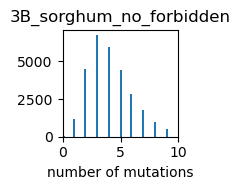

46195
# of wt: 28


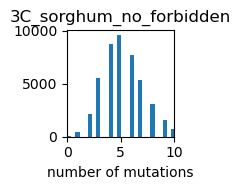

24397
# of wt: 239


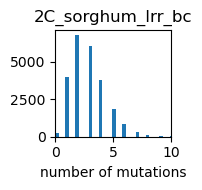

29121
# of wt: 452


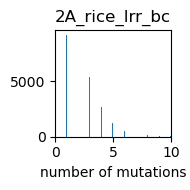

88757
# of wt: 3325


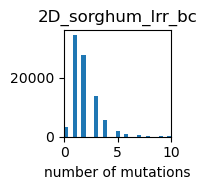

25714
# of wt: 239


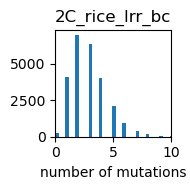

30316
# of wt: 452


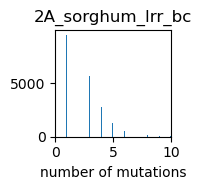

33713
# of wt: 1


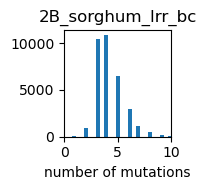

In [ ]:
# for the 3B and 3C with truseq removed
dout_no_truseq = '/data/davidding/dms/dms_plants/data/clean/illumina/lrr_muts_no_forbidden/'

# for the 2s that did not go through truseq removal
din_2s = '/data/davidding/dms/dms_plants/data/clean/illumina/lrr_muts/'

#output directory of original positin, new Reference, cleaned dataframes
dout_oprc = '/data/davidding/dms/dms_plants/data/clean/illumina/lrr_oprc/'

# clean the 3B and 3C
for f_name in ['3B_sorghum_no_forbidden', '3C_sorghum_no_forbidden']:
    add_reref_clean_hr_cols(f_name, dout_no_truseq, dout_oprc)

# clean the 2s
for f_name in [f[:-4] for f in listdir(din_2s) if f.startswith('2')]:
    add_reref_clean_hr_cols(f_name, din_2s, dout_oprc)

# 7. shift mutants into easier to read positions

- based on fixed position in constants

In [ ]:
importlib.reload(nt)
# final dataframes are:
din_oprc = '/data/davidding/dms/dms_plants/data/clean/illumina/lrr_oprc/'
dout = '/data/davidding/dms/dms_plants/data/clean/illumina/lrr_rcs/'
s_to_df = {'_'.join(f.split('_')[:2]): pd.read_csv(din_oprc + f) for f in listdir(din_oprc) if f.endswith('bc.csv') or f.endswith('no_forbidden.csv')}

for s_name, df in s_to_df.items():
    gene_n = s_name.split('_')[0]
    #display(df)
    print(df.columns)
    df = nt.add_tss0_mut_col(df, gene_n, mut_col = 'muts_oprc')

    # add mean_lrr column if it doesn't exist
    if 'mean_lrr' not in df.columns:
        df['mean_lrr'] = df[['lrr_rep1', 'lrr_rep2']].mean(axis=1)

    df.to_csv(dout + s_name + '.csv', index=False)


Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'bc_count_dna_rep3', 'bc_count_rna_rep3',
       'lrr_rep3', 'len_bc_rep3', 'mean_lrr_all', 'bc_count_dna_rep4',
       'bc_count_rna_rep4', 'lrr_rep4', 'len_bc_rep4', 'Unnamed: 0',
       'raw_bc_with_5_5prime_bases', 'raw_muts', 'consensus_seq_len',
       'muts_orig_pos', 'len_bc', 'bc_from_raw_bc', 'matching_bcs', 'muts_opr',
       'muts_oprc', 'num_muts'],
      dtype='object')
Index(['bc', 'bc_count_dna_rep1', 'bc_count_rna_rep1', 'lrr_rep1',
       'len_bc_rep1', 'bc_count_dna_rep2', 'bc_count_rna_rep2', 'lrr_rep2',
       'len_bc_rep2', 'mean_lrr', 'bc_count_dna_rep3', 'bc_count_rna_rep3',
       'lrr_rep3', 'len_bc_rep3', 'mean_lrr_all', 'Unnamed: 0',
       'raw_bc_with_5_5prime_bases', 'raw_muts', 'consensus_seq_len',
       'muts_orig_pos', 'len_bc', 'bc_from_raw_bc', 'matching_bcs',
       'list_po